In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import scipy.sparse as sparse
from tqdm import tqdm

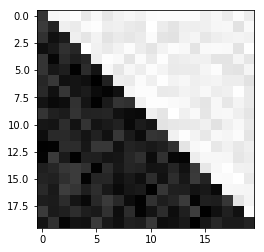

In [2]:
n = 20
ref_img = 0.8 + 0.2 * np.random.uniform(size=(n, n))
ref_img[np.tril_indices_from(ref_img)] -= 0.8
ref_img = (ref_img * 255)[:, :, None].astype(int)

target_img = ref_img

plt.imshow(ref_img[:, :, 0], cmap="Greys_r")

problem = "smoothing_BW"

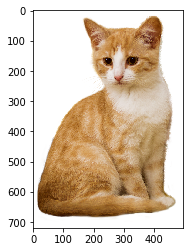

In [3]:
ref_img = (mpimg.imread("pictures/cat_color.png")[:, :, :4] * 255).astype(int)

target_img = ref_img

plt.imshow(ref_img)

problem = "smoothing_color"

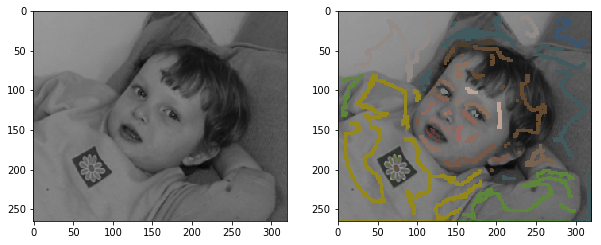

In [4]:
ref_img_BW_pil = Image.open("pictures/child_BW.bmp").convert("YCbCr")
ref_img_marked_pil = Image.open("pictures/child_marked.bmp").convert("YCbCr")

ref_img = np.asarray(ref_img_BW_pil)[:, :, :1]
target_img = np.asarray(ref_img_marked_pil)[:, :, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ref_img_BW_pil.convert("RGB"))
ax[1].imshow(ref_img_marked_pil.convert("RGB"))

problem = "colorization"

In [5]:
class BilateralGrid:
    
    def __init__(self, ref_img, sigma):
        self.ref_img = ref_img
        self.sigma = sigma
        
        self.compute_everything()
        
    def compute_everything(self):
        self.compute_useful_stuff()
        self.compute_splat()
        self.compute_blur()
        
    def compute_useful_stuff(self):
        
        self.D = 2 + self.ref_img.shape[2]
        
        self.grid_shape = np.hstack([
            np.ceil(self.ref_img.shape[:2] / self.sigma[:2]) + 1,
            np.ceil(255 / self.sigma[2:]) + 1
        ]).astype(int)
        self.grid_indices = np.indices(self.grid_shape)
        
        self.n_pixels = np.prod(self.ref_img.shape[:2])
        self.n_vertices = np.prod(self.grid_shape)
        
        self.coord_to_vertex = np.arange(self.n_vertices).reshape(self.grid_shape).astype(int)

        self.vertex_to_coord = np.stack([
            self.grid_indices[dim].flatten() for dim in range(self.D)
        ], axis=1)
        
        self.x_ref_img = np.indices(self.ref_img.shape[:2])[0].flatten()
        self.y_ref_img = np.indices(self.ref_img.shape[:2])[1].flatten()
        
        self.pos_ref_img = np.hstack([
            self.x_ref_img[:, None],
            self.y_ref_img[:, None],
            self.ref_img[self.x_ref_img, self.y_ref_img]
        ])
        
    def compute_splat(self):
        
        self.pos_grid = np.rint(self.pos_ref_img / self.sigma).astype(int)
        
        self.nearest_neighbors = self.coord_to_vertex[tuple(
            self.pos_grid[:, dim]
            for dim in range(self.D)
        )]
        self.useful_vertices = np.sort(np.unique(self.nearest_neighbors))
        self.n_useful_vertices = len(self.useful_vertices)
        self.useful_vertex_to_coord = self.vertex_to_coord[self.useful_vertices]
        
        S = sparse.lil_matrix((self.n_useful_vertices, self.n_pixels), dtype=np.float)
        for uv_ind in tqdm(range(len(self.useful_vertices)), desc="Computing splat matrix"):
            uv = self.useful_vertices[uv_ind]
            nearby_pixels = np.where(self.nearest_neighbors == uv)[0]
            S[uv_ind, nearby_pixels] = 1
        self.S = S.tocsr()
        
    def compute_blur(self):
        
        B = sparse.lil_matrix((self.n_vertices, self.n_vertices), dtype=np.float)
        B[np.diag_indices_from(B)] = 6

        possible_neighbor_steps = [
            np.array([0] * dim + [1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ] + [
            np.array([0] * dim + [-1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ]

        for neighbor_step in tqdm(possible_neighbor_steps, desc="Computing blur matrix"):
            
            neighbors_coord = self.vertex_to_coord[np.arange(self.n_vertices)] + neighbor_step

            neighbors_coord_acceptable = True
            for dim, dim_size in enumerate(self.grid_shape):
                neighbors_coord_acceptable = (
                    neighbors_coord_acceptable &
                    (neighbors_coord[:, dim] >= 0) &
                    (neighbors_coord[:, dim] < dim_size)
                )

            acceptable_neighbors = self.coord_to_vertex[tuple(
                    neighbors_coord[neighbors_coord_acceptable][:, dim]
                    for dim in range(self.D)
            )]
            vertices_with_acceptable_neighbors = np.arange(self.n_vertices)[neighbors_coord_acceptable]
            B[vertices_with_acceptable_neighbors, acceptable_neighbors] = 1

        B = B[np.ix_(self.useful_vertices, self.useful_vertices)]
        self.B = B.tocsr()

In [6]:
def bistochastize(S, B, iterations=50):
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(B.shape[1])
    for it in range(iterations):
        new_n = np.sqrt((n * m) / (B.dot(n)))
        if np.linalg.norm(new_n - n) < 1e-5:
            break
        else:
            n = new_n
    Dn = sparse.csr_matrix(np.diag(n))
    Dm = sparse.csr_matrix(np.diag(m))
    return Dn, Dm

In [7]:
def prec_conj_grad(A, b, init, M_1, iterations=25):
    x = init
    r = b - A.dot(x)
    d = M_1(r)
    delta_new = r.dot(d)
    for it in range(iterations):
        q = A.dot(d)
        alpha = delta_new / d.dot(q)
        x = x + alpha * d
        r = r - alpha * q
        s = M_1(r)
        delta_old = delta_new
        delta_new = r.dot(s)
        beta = delta_new / delta_old
        d = s + beta * d
    return x

In [8]:
def M_jacobi(y, A):
    return y / A.diagonal()

In [9]:
def bilateral_representation(V, sigma):
    D = V.shape[1]
    grid_shape = np.ceil((V.max(axis=0) / sigma) + 1).astype(int)
    
    n_abstract_pixels = len(V)
    n_vertices = np.prod(grid_shape)

    coord_to_vertex = np.arange(n_vertices).reshape(grid_shape).astype(int)

    grid_indices = np.indices(grid_shape)
    vertex_to_coord = np.stack([
        grid_indices[dim].flatten()
        for dim in range(D)
    ], axis=1)
    
    pos_grid = np.rint(V / sigma).astype(int)

    nearest_neighbors = coord_to_vertex[tuple(zip(*pos_grid))]
    useful_vertices = np.sort(np.unique(nearest_neighbors))
    n_useful_vertices = len(useful_vertices)
    
    S = sparse.lil_matrix((n_useful_vertices, n_abstract_pixels), dtype=np.float)
    
    for uv_ind in range(len(useful_vertices)):
        uv = useful_vertices[uv_ind]
        nearby_pixels = np.where(nearest_neighbors == uv)[0]
        S[uv_ind, nearby_pixels] = 1
        
    return S, vertex_to_coord[useful_vertices]

In [10]:
def build_pyramid(useful_vertex_to_coord):
    V = useful_vertex_to_coord
    S_pyr = []
    while len(V) > 1:
        Sk, V = bilateral_representation(V, 2 * np.ones(V.shape[1]))
        S_pyr.append(Sk)
    return S_pyr

def build_P(S_pyr):
    prod = sparse.eye(S_pyr[0].shape[1])
    P = prod
    for s in S_pyr:
        prod = s.dot(prod)
        P = sparse.vstack([P, prod])
    return P

In [11]:
def M_hier(y, A, P, alpha=2, beta=5):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    Py = P.dot(y)
    PA = P.dot(A.diagonal())
    
    z_weight = 1
    
    return P.T.dot(z_weight * P1 * Py / PA)

def y_hier(S, C, T, P, alpha=2, beta=5):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    PSc = P.dot(S.dot(C))
    PSct = P.dot(S.dot(C * T))

    z_weight = 1

    y_init = (
        P.T.dot(z_weight * PSct / P1) /
        P.T.dot(z_weight * PSc / P1)
    )
    
    return y_init

In [12]:
def solve(bilateral_grid, C, T, lambd, precond_init_method="simple"):
    S, B = bilateral_grid.S, bilateral_grid.B
    Dn, Dm = bistochastize(S, B)
    
    A = lambd * (Dm - Dn.dot(B).dot(Dn)) + sparse.diags(S.dot(C))
    b = S.dot(C * T)
    c = 0.5 * (C * T).dot(T)
    
    if precond_init_method == "simple":
        y_init = S.dot(C * T) / np.clip(S.dot(C), a_min=1, a_max=None)
        def M_1(y):
            return M_jacobi(y, A)
    
    elif precond_init_method == "hierarchical":
        S_pyr = build_pyramid(bilateral_grid.useful_vertex_to_coord)
        P = build_P(S_pyr)
        y_init = y_hier(S, C, T, P)
        def M_1(y):
            return M_hier(y, A, P)
    
    y_opt = prec_conj_grad(A, b, init=y_init, M_1=M_1)
    return y_opt

In [13]:
def show_smoothing(ref_img, new_img, problem):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    if problem == "smoothing_BW":
        ref_img, new_img = ref_img[:, :, 0], new_img[:, :, 0]
        cmap= "Greys_r"
    else:
        cmap = None
        
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(ref_img, cmap=cmap)
    ax[0].set_title("Original image")
    ax[1].imshow(new_img, cmap=cmap)
    ax[1].set_title("Smoothed image")
    ax[2].imshow((ref_img + 0.5 * (ref_img - new_img)).astype(int), cmap=cmap)
    ax[2].set_title("Sharpened image")
    plt.show()

def show_colorization(ref_img, target_img, new_img):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(Image.fromarray(ref_img[:, :, 0], mode="L").convert("RGB"))
    ax[0].set_title("Original BW image")
    ax[1].imshow(Image.fromarray(target_img, mode="YCbCr").convert("RGB"))
    ax[1].set_title("User-marked BW image")
    ax[2].imshow(Image.fromarray(new_img, mode="YCbCr").convert("RGB"))
    ax[2].set_title("Automatically colorized image")
    fig.savefig("colorization.png")

In [14]:
sigma_xy = 10
sigma_l = 20
sigma_uv = 20
sigma_alpha = 100

sigma = np.array([
    sigma_xy, sigma_xy, sigma_l, sigma_uv, sigma_uv, sigma_alpha
])[:2 + ref_img.shape[2]]

In [15]:
bilateral_grid = BilateralGrid(ref_img, sigma)
S, B = bilateral_grid.S, bilateral_grid.B
print(bilateral_grid.grid_shape)

Computing blur matrix: 100%|██████████| 6/6 [00:00<00:00, 332.35it/s]


[28 33 14]


Filtering channels: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


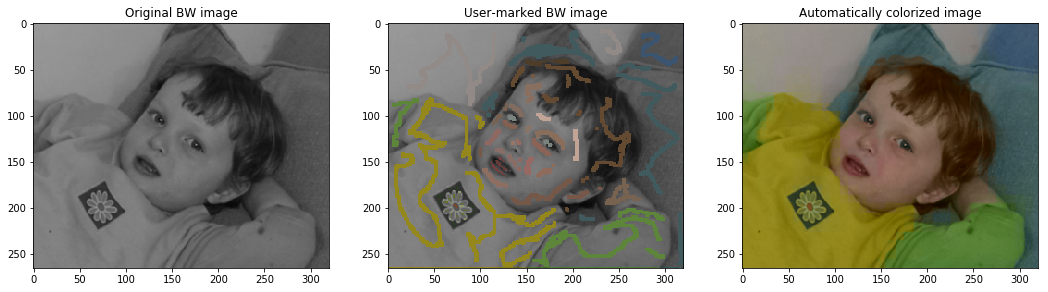

In [16]:
lambd = 1
precond_init_method = "hierarchical"

new_img = np.empty_like(target_img)

if "smoothing" in problem:
    
    for channel in tqdm(range(target_img.shape[2]), desc="Filtering channels"):
        
        T = ref_img[:, :, channel].flatten()
        C = np.ones_like(T)

        y = solve(bilateral_grid, C, T, lambd)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_smoothing(ref_img, new_img, problem)

elif problem == "colorization":
    
    new_img[:, :, 0] = ref_img[:, :, 0]

    for channel in tqdm(range(1, 3), desc="Filtering channels"):
        
        T = target_img[:, :, channel].flatten()
        C = np.zeros_like(T)
        C[T != np.median(T)] = 1
        
        y = solve(bilateral_grid, C, T, lambd, precond_init_method)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_colorization(ref_img, target_img, new_img)